# AutoInt example

## Imports

### A bunch of third-party libraries

In [53]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from torch.utils.data import DataLoader
from torchmeta.modules import MetaModule

### Our libraries

In [54]:
import sys
import os
    
from autoint.session import Session
import autoint.autograd_modules as autoint

## A class to create coordinates from a 1D function we wish to fit

In [55]:
class Implicit1DWrapper(torch.utils.data.Dataset):
    def __init__(self, range, fn, grad_fn=None, integral_fn=None, sampling_density=100,
                 train_every=10):

        avg = (range[0] + range[1]) / 2

        coords = self.get_samples(range, sampling_density)
        self.fn_vals = fn(coords)
        self.train_idx = torch.arange(0, coords.shape[0], train_every).float()

        #coords = (coords - avg) / (range[1] - avg)
        self.grid = coords
        self.grid.requires_grad_(True)
        #self.val_grid = val_coords

        if grad_fn is None:
            grid_gt_with_grad = coords
            grid_gt_with_grad.requires_grad_(True)
            fn_vals_with_grad = fn((grid_gt_with_grad * (range[1] - avg)) + avg)
            gt_gradient = torch.autograd.grad(fn_vals_with_grad, [grid_gt_with_grad],
                                              grad_outputs=torch.ones_like(grid_gt_with_grad), create_graph=True,
                                              retain_graph=True)[0]
            try:
                gt_hessian = torch.autograd.grad(gt_gradient, [grid_gt_with_grad],
                                                 grad_outputs=torch.ones_like(gt_gradient), retain_graph=True)[0]
            except Exception as e:
                gt_hessian = torch.zeros_like(gt_gradient)

        else:
            gt_gradient = grad_fn(coords) 
            gt_hessian = torch.zeros_like(gt_gradient)

        self.integral_fn = integral_fn
        if integral_fn:
            self.integral_vals = integral_fn(coords)

        self.gt_gradient = gt_gradient.detach()
        self.gt_hessian = gt_hessian.detach()

    def get_samples(self, range, sampling_density):
        num = int(range[1] - range[0])*sampling_density
        avg = (range[0] + range[1]) / 2
        coords = np.linspace(start=range[0], stop=range[1], num=num)
        coords.astype(np.float32)
        coords = torch.Tensor(coords).view(-1, 1)
        return coords

    def get_num_samples(self):
        return self.grid.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if self.integral_fn is not None:
            return {'coords':self.grid}, {'integral_func': self.integral_vals, 'func':self.fn_vals,
                    'gradients':self.gt_gradient, 'val_func': self.val_fn_vals,
                    'val_coords': self.val_grid, 'hessian':self.gt_hessian}
        else:
            return {'idx': self.train_idx, 'coords':self.grid}, \
                   {'func': self.fn_vals, 'gradients':self.gt_gradient,
                    'coords': self.grid}

## Different 1D functions we want to integrate

In [56]:
def cos_fn(coords):
  return torch.cos(10*coords)

def polynomial_fn(coords):
    return .1*coords**5 - .2*coords**4 + .2*coords**3 - .4*coords**2 + .1*coords

def sinc_fn(coords):
    coords[coords == 0] += 1
    return torch.div(torch.sin(20*coords), 20*coords)

def linear_fn(coords):
    return 1.0 * coords

def xcosx_fn(coords):
    return coords * torch.cos(coords)

def integral_xcosx_fn(coords):
    return coords*torch.sin(coords) + torch.cos(coords)

## Setting up the integral network & the grad network

We define an integral network using the AutoInt API. Here the integral network is a MLP with sine non-linearities: a SIREN.

In [57]:
class SIREN(MetaModule):
    def __init__(self, session):
        super().__init__()

        self.net = [] 
        self.input = autoint.Input(torch.Tensor(1, 1), id='x_coords')

        self.net.append(autoint.Linear(1, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 1))

        self.net = torch.nn.Sequential(*self.net)
        self.session = session

    def input_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Input):
                m.set_value(input_tensor, grad=True)

    def constant_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Constant):
                m.set_value(input_tensor, grad=False)
    
    def forward(self, x):
        with torch.no_grad():
            input_init_func = partial(self.input_init, x[:, 0, None])
            self.input.apply(input_init_func)

        input_ctx = autoint.Value(x, self.session)

        out1 = self.input(input_ctx)
        return self.net(out1)

In AutoInt, a session will handle the derivation of the integral network into the grad network for you. It takes care of the reassembly of the weights too.

In [58]:
integralnet_session = Session()

Creating session: 822902106


We instantiate the integral net we defined earlier. The session can be thought as representing the integral network.

In [59]:
net = SIREN(integralnet_session)
 #add metal to the mix
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
net.to(device)

SIREN(
  (input): Input()
  (net): Sequential(
    (0): Linear()
    (1): Sine()
    (2): Linear()
    (3): Sine()
    (4): Linear()
    (5): Sine()
    (6): Linear()
    (7): Sine()
    (8): Linear()
  )
  (session): Session()
)

In [60]:
device

device(type='mps')

We can evaluate the SIREN we instantiated using the forward function as we would do for any Pytorch module.

In [61]:
x = torch.ones(1, 1).to(device)# defines a dummy input
y = torch.ones(1, 1).to(device)
x.requires_grad_(True)

session_input = {'x_coords': x,
                 #'y_coords': y,
                 'params': None}

y = net(x)

forward_siren_evaluation = y.data
print(f"result of forward SIREN evaluation={forward_siren_evaluation}")

result of forward SIREN evaluation=tensor([[0.0580]], device='mps:0', grad_fn=<AddBackward0>)


Evaluating the session also yields the output of the network. We must evaluate the session at least once (as done above) to initialize the session properly and get the backward session

In [62]:
integralnet_session_evaluation = integralnet_session(session_input)
print(f"result of forward session evaluation={integralnet_session_evaluation}")

result of forward session evaluation=tensor([[0.0580]], device='mps:0', grad_fn=<AddBackward0>)


We can check the two evaluations (the evaluation of the integral network via forward and of the session representing the integral network) are the same

In [63]:
error_fn = torch.nn.MSELoss()
print(f"Error between session and network evaluation={error_fn(forward_siren_evaluation.squeeze(), integralnet_session_evaluation.squeeze())}")

Error between session and network evaluation=0.0


Calling the function get_backward_graph() on the session instantiates another session that represents the grad network. **(this can only be done if the network has been run once!)**



In [64]:
gradnet_session = integralnet_session.get_backward_graph()

Creating session: 822885244


We can visualize the integral network we created (by visualizing its associated session)

In [65]:
integralnet_session.draw()

AttributeError: module 'pydot' has no attribute 'quote_id_if_necessary'

We can also visualize the grad network (contained in the backward session):

In [54]:
gradnet_session.draw()

AttributeError: module 'pydot' has no attribute 'quote_id_if_necessary'

## Fitting the grad network

We choose the function we want to calculate the integral using AutoInt.

In [66]:
func_to_fit = integral_xcosx_fn

We create the dataloader that will create the pairs of datapoints of the form (input coordinate, output of the function to integrate) for us.

In [67]:
dataset = Implicit1DWrapper([-1,10], fn=func_to_fit, \
                            sampling_density=1000, train_every=1)
dataloader = DataLoader(dataset,shuffle=True, batch_size=1, \
                        pin_memory=True, num_workers=0)

def dict2cuda(d):
    tmp = {}
    for key, value in d.items():
        if isinstance(value, torch.Tensor):
            tmp.update({key: value.to(device)})
        else:
            tmp.update({key: value})
    return tmp

A minimal example of a training loop to fit the function:

In [68]:
epochs = 1000

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr=5e-5, params=net.parameters(),amsgrad=True)

print_loss_every = 50
losses = []

for e in range(epochs):
  for step, (input, gt) in enumerate(dataloader):
      input = dict2cuda(input)
      gt = dict2cuda(gt)
      
      gradnet_output = gradnet_session.compute_graph_fast2({'x_coords': input['coords'],
                                                            'params': None})
      loss = loss_fn(gradnet_output,gt['func']).mean()

      optimizer.zero_grad()
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
    
  if not e % print_loss_every:
      print(f"{e}/{epochs}: loss={loss}")

0/1000: loss=13.446825981140137
50/1000: loss=9.699758529663086
100/1000: loss=8.393468856811523
150/1000: loss=7.452095031738281
200/1000: loss=6.647197246551514
250/1000: loss=5.942888259887695
300/1000: loss=5.32542610168457
350/1000: loss=4.78580904006958
400/1000: loss=4.303192138671875
450/1000: loss=3.869208812713623
500/1000: loss=3.4755804538726807
550/1000: loss=3.1164424419403076
600/1000: loss=2.798607349395752
650/1000: loss=2.522096872329712
700/1000: loss=2.264122486114502
750/1000: loss=2.048189640045166
800/1000: loss=1.8457914590835571
850/1000: loss=1.6738758087158203
900/1000: loss=1.524338722229004
950/1000: loss=1.3902242183685303


Text(0.5, 1.0, 'Loss vs Epoch for SIREN')

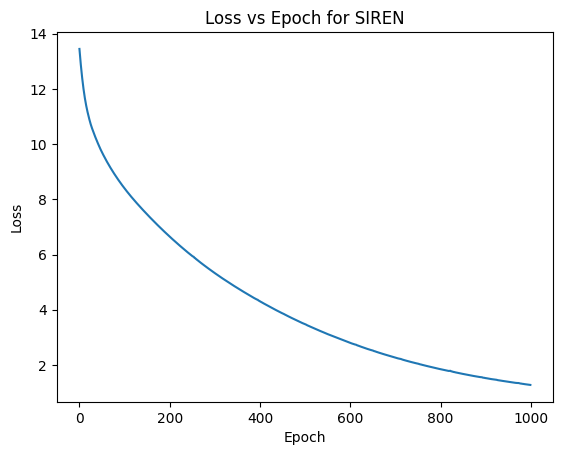

In [69]:
plt.plot(np.arange(0,1000), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for SIREN')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

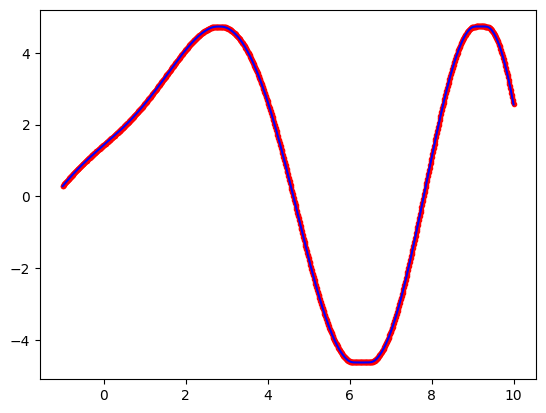

In [78]:
x_coords = torch.linspace(-1,10,1000)[:,None].to(device)
grad_vals = func_to_fit(x_coords).cpu()
# fitted_grad_vals = gradnet_session.compute_graph_fast2({'x_coords': x_coords,
#                                                        'params': None}).cpu()
integral_vals = integralnet_session.compute_graph_fast2({'x_coords': x_coords,
                                                        'params': None}).cpu()
int_vals2 = net(x_coords).data.detach().cpu()
x_coords = x_coords.cpu()
# plt.plot(x_coords,grad_vals,'-k', label='Function to integrate')
plt.plot(x_coords,int_vals2,'.r', label='Grad network')
plt.plot(x_coords,integral_vals.detach(),'-b', label='Integral network')
plt.plot(x_coords,int_vals2 - integral_vals,'-k', label='Function to integrate')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
